170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 0.0160 - val_loss: 0.0055
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0053 - val_loss: 0.0050
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 9/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 10/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0034 - val_loss: 0.0034
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
PSNR: 24.701506413089437 dB


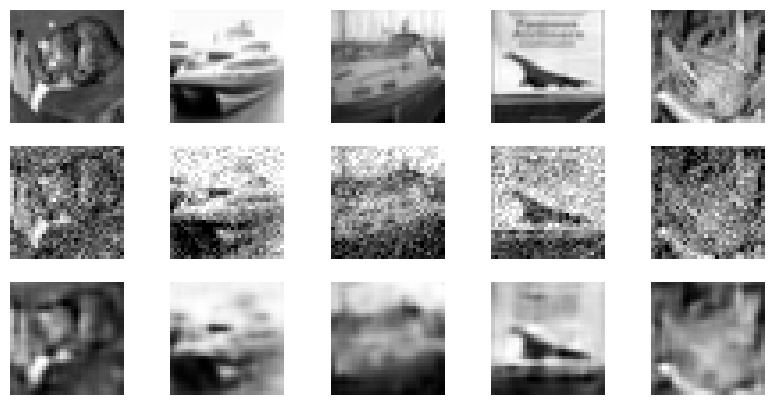

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras.models import Model
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10

def load_and_preprocess_data():
    # Load dataset
    (x_train, _), (x_test, _) = cifar10.load_data()

    # Normalize pixel values
    x_train, x_test = x_train / 255.0, x_test / 255.0

    # Convert to grayscale
    x_train = np.mean(x_train, axis=-1, keepdims=True)
    x_test = np.mean(x_test, axis=-1, keepdims=True)

    return x_train, x_test

def add_noise(images, noise_type="gaussian"):
    noisy_images = images.copy()

    if noise_type == "gaussian":
        mean, std = 0, 0.1
        noise = np.random.normal(mean, std, images.shape)
        noisy_images += noise
    elif noise_type == "salt_pepper":
        prob = 0.02
        rnd = np.random.rand(*images.shape)
        noisy_images[rnd < prob] = 0
        noisy_images[rnd > 1 - prob] = 1

    return np.clip(noisy_images, 0, 1)

def build_autoencoder():
    input_img = Input(shape=(32, 32, 1))

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder

def train_autoencoder(autoencoder, x_train, x_train_noisy, x_test, x_test_noisy):
    autoencoder.fit(x_train_noisy, x_train, epochs=10, batch_size=128, validation_data=(x_test_noisy, x_test))

def evaluate_model(autoencoder, x_test, x_test_noisy):
    decoded_images = autoencoder.predict(x_test_noisy)

    def psnr(img1, img2):
        mse = np.mean((img1 - img2) ** 2)
        if mse == 0:
            return 100
        max_pixel = 1.0
        return 20 * np.log10(max_pixel / np.sqrt(mse))

    psnr_value = psnr(x_test, decoded_images)
    print(f'PSNR: {psnr_value} dB')

    return decoded_images

def display_images(original, noisy, restored, n=5):
    plt.figure(figsize=(10, 5))
    for i in range(n):
        plt.subplot(3, n, i + 1)
        plt.imshow(original[i].squeeze(), cmap='gray')
        plt.axis('off')

        plt.subplot(3, n, i + 1 + n)
        plt.imshow(noisy[i].squeeze(), cmap='gray')
        plt.axis('off')

        plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(restored[i].squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()

# Execute the workflow
x_train, x_test = load_and_preprocess_data()
x_train_noisy = add_noise(x_train, "gaussian")
x_test_noisy = add_noise(x_test, "gaussian")

autoencoder = build_autoencoder()
train_autoencoder(autoencoder, x_train, x_train_noisy, x_test, x_test_noisy)

decoded_images = evaluate_model(autoencoder, x_test, x_test_noisy)
display_images(x_test, x_test_noisy, decoded_images)


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import time
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical

def load_cifar100():
    (x_train, y_train), (x_test, y_test) = cifar100.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0
    y_train, y_test = to_categorical(y_train, 100), to_categorical(y_test, 100)
    return x_train, y_train, x_test, y_test

def build_alexnet():
    model = Sequential([
        Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=(32, 32, 3), padding='same'),
        MaxPooling2D((3, 3), strides=2, padding='same'), # Changed padding to 'same'
        BatchNormalization(),
        Conv2D(256, (5, 5), activation='relu', padding='same'),
        MaxPooling2D((3, 3), strides=2, padding='same'), # Changed padding to 'same'
        BatchNormalization(),
        Conv2D(384, (3, 3), activation='relu', padding='same'),
        Conv2D(384, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((3, 3), strides=2, padding='same'), # Changed padding to 'same'
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(100, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_vgg16():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(100, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def train_and_evaluate(model, x_train, y_train, x_test, y_test, name):
    start_time = time.time()
    model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test))
    end_time = time.time()
    loss, accuracy = model.evaluate(x_test, y_test)
    print(f"{name} - Accuracy: {accuracy:.4f}, Loss: {loss:.4f}, Time: {end_time - start_time:.2f} seconds")
    return accuracy, loss, end_time - start_time

x_train, y_train, x_test, y_test = load_cifar100()

alexnet = build_alexnet()
vgg16 = build_vgg16()

alexnet_results = train_and_evaluate(alexnet, x_train, y_train, x_test, y_test, "AlexNet")
vgg16_results = train_and_evaluate(vgg16, x_train, y_train, x_test, y_test, "VGG16")

print("Comparison:")
print(f"AlexNet - Accuracy: {alexnet_results[0]:.4f}, Loss: {alexnet_results[1]:.4f}, Time: {alexnet_results[2]:.2f}s")
print(f"VGG16 - Accuracy: {vgg16_results[0]:.4f}, Loss: {vgg16_results[1]:.4f}, Time: {vgg16_results[2]:.2f}s")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.0307 - loss: 4.3942 - val_accuracy: 0.0723 - val_loss: 4.2139
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 13ms/step - accuracy: 0.0936 - loss: 3.8548 - val_accuracy: 0.1454 - val_loss: 3.5989
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.1429 - loss: 3.5578 - val_accuracy: 0.1505 - val_loss: 3.5554
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.1798 - loss: 3.3758 - val_accuracy: 0.1859 - val_loss: 3.4456
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.2148 - loss: 3.1934 - val_accuracy: 0.1802 - val_loss: 3.4715
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.2407 - loss: 3.0605 - val_accuracy: 0.1894 - val_loss: 3.5708
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.2688 - loss: 2.9208 - val_accuracy: 0.2514 - val_loss: 3.0985
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.2908 - loss: 2.8025 - 